In [1]:
## Data Preprocessing

In [2]:
import cv2
import os

data_path = 'dataset'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]

label_dict = dict(zip(categories, labels))

print(label_dict)
print(categories)
print(labels)


{'with mask': 0, 'without mask': 1}
['with mask', 'without mask']
[0, 1]


In [3]:
img_size = 100
data = []
target = []

for category in categories:
    folder_path = os.path.join(data_path, category)
    img_names = os.listdir(folder_path)
    
    for img_name in img_names:
        img_path = os.path.join(folder_path, img_name)
        img = cv2.imread(img_path)
    
        try:
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray, (img_size, img_size))
            data.append(resized)
            target.append(label_dict[category])
        
        
        except Exception as e:
            print("Exception:", e)


In [4]:
import numpy as np

data = np.array(data) / 255.0
data = np.reshape(data, (data.shape[0], img_size, img_size, 1))
target = np.array(target)

from keras.utils import np_utils

new_target = np_utils.to_categorical(target)

Using TensorFlow backend.


In [5]:
np.save('data', data)
np.save('target', new_target)

In [6]:
## Training the CNN

In [7]:
data = np.load('data.npy')
target = np.load('target.npy')

In [8]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D
from keras.callbacks import ModelCheckpoint


model = Sequential()

model.add(Conv2D(100, (3,3), input_shape = data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
# 1st CNN layer followed by Relu anf MaxPooling layer

model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
#2nd CNN layer followed by relu and MaxPooling layer

model.add(Flatten())
model.add(Dropout(0.5))
#flatten layer to stack the output convolutions from second layer

model.add(Dense(50, activation = 'relu'))
#dense layer of 64 neurons

model.add(Dense(2, activation = 'softmax'))
#the final layer with two outputs for two categories

model.compile(loss = 'binary_crossentropy', optimizer ='adam', metrics = ['accuracy'])



Instructions for updating:
Colocations handled automatically by placer.


In [9]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_target, test_target = train_test_split(data, target, test_size = 0.2)


In [10]:
checkpoint = ModelCheckpoint(',odel-{epoch:03d}.model', monitor = 'val_loss', verbose = 0,
                            save_best_only = True, mode = 'auto')
history = model.fit(train_data, train_target, epochs = 20,
                   callbacks = [checkpoint], validation_split = 0.2)

Instructions for updating:
Use tf.cast instead.
Train on 880 samples, validate on 220 samples
Epoch 1/20
880/880 [==============================] - 70s 79ms/step - loss: 0.7246 - accuracy: 0.5330 - val_loss: 0.6735 - val_accuracy: 0.5136
Epoch 2/20
880/880 [==============================] - 74s 84ms/step - loss: 0.5934 - accuracy: 0.6852 - val_loss: 0.5710 - val_accuracy: 0.7364
Epoch 3/20
880/880 [==============================] - 76s 86ms/step - loss: 0.4507 - accuracy: 0.7830 - val_loss: 0.4835 - val_accuracy: 0.7864
Epoch 4/20
880/880 [==============================] - 69s 78ms/step - loss: 0.2910 - accuracy: 0.8818 - val_loss: 0.3277 - val_accuracy: 0.8955
Epoch 5/20
880/880 [==============================] - 71s 80ms/step - loss: 0.2446 - accuracy: 0.9034 - val_loss: 0.3025 - val_accuracy: 0.9045
Epoch 6/20
880/880 [==============================] - 71s 81ms/step - loss: 0.1537 - accuracy: 0.9477 - val_loss: 0.2844 - val_accuracy: 0.8864
Epoch 7/20
880/880 [======================

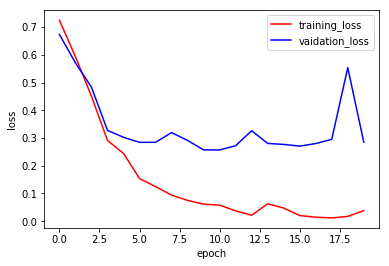

In [11]:
from matplotlib import pyplot as plt
plt.plot(history.history['loss'], 'r', label= "training_loss")
plt.plot(history.history['val_loss'], 'b', label = 'vaidation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

##Overfitting the model

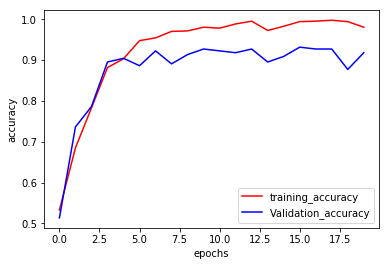

In [12]:
plt.plot(history.history['accuracy'], 'r', label = 'training_accuracy')
plt.plot(history.history['val_accuracy'], 'b', label = 'Validation_accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()

In [13]:
print(model.evaluate(test_data, test_target))

276/276 [==============================] - 8s 28ms/step
[0.21563116061514703, 0.9384058117866516]


In [14]:
## Detecting Mask

In [15]:
from keras.models import load_model


In [16]:
model = load_model('model-017.model')

face_clsfr=cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

source=cv2.VideoCapture(0)

labels_dict={0:'with_mask',1:'without_mask'}
color_dict={0:(0,255,0),1:(0,0,255)}

In [17]:
while(True):

    ret,img=source.read()
    gray=cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    faces=face_clsfr.detectMultiScale(gray,1.3,5)  

    for x,y,w,h in faces:
    
        face_img=gray[y:y+w,x:x+w]
        resized=cv2.resize(face_img,(100,100))
        normalized=resized/255.0
        reshaped=np.reshape(normalized,(1,100,100,1))
        result=model.predict(reshaped)

        label=np.argmax(result,axis=1)[0]
      
        cv2.rectangle(img,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.rectangle(img,(x,y-40),(x+w,y),color_dict[label],-1)
        cv2.putText(img, labels_dict[label], (x, y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
        
    cv2.imshow('LIVE',img)
    key=cv2.waitKey(1)
    
    if(key==27):
        break
        
cv2.destroyAllWindows()
source.release()